Step 1: Data Preparation

In [ ]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/mohiychoithwani/vehicle-image-classification-dataset-4-classes
!unzip archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14.9M  100 14.9M    0     0  20.3M      0 --:--:-- --:--:-- --:--:-- 71.4M
Archive:  archive.zip
  inflating: images/bicycle/0.jpg    
  inflating: images/bicycle/1.jpg    
  inflating: images/bicycle/10.jpg   
  inflating: images/bicycle/100.jpg  
  inflating: images/bicycle/101.jpg  
  inflating: images/bicycle/103.jpg  
  inflating: images/bicycle/104.jpg  
  inflating: images/bicycle/107.jpg  
  inflating: images/bicycle/108.jpg  
  inflating: images/bicycle/11.jpg   
  inflating: images/bicycle/112.jpg  
  inflating: images/bicycle/113.jpg  
  inflating: images/bicycle/114.jpg  
  inflating: images/bicycle/116.jpg  
  inflating: images/bicycle/117.jpg  
  inflating: images/bicycle/118.jpg  
  inflating: images/bicycle/12.jpg   
  inflating: ima

Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

Hyperparameters

In [ ]:
num_classes = 4  # bicycle, car, motor bike, truck
batch_size = 32
num_epochs = 30
learning_rate = 0.01
classes = ['bicycle', 'car', 'motor bike', 'truck']

Step 2: Choose a Pre-Trained Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet50(pretrained=True)

# Modify final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.7MB/s]


Step 3: Combine Everything: Resize Image, Transform to ToTensor, and Normalize

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

data_path = '/content/images'
full_dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Step 4: Model Training

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 0.1 every 5 epochs

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, device):
    training_acc = []
    validation_acc = []
    training_loss = []
    epoch_nums = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        training_loss.append(epoch_loss / len(train_loader))
        training_acc.append(correct / total)

        # Evaluate on validation set
        val_accuracy = evaluate_model(model, val_loader, device)
        validation_acc.append(val_accuracy)

        epoch_nums.append(epoch + 1)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Training Accuracy: {correct / total:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        scheduler.step()

    return training_loss, training_acc, validation_acc, epoch_nums


def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [8]:
training_loss, training_acc, validation_acc, epoch_nums = train_model(
    model, train_loader, val_loader, num_epochs, device
)

Epoch [1/30], Loss: 1.0347, Training Accuracy: 0.5899, Validation Accuracy: 0.8806
Epoch [2/30], Loss: 0.6450, Training Accuracy: 0.8927, Validation Accuracy: 0.8657
Epoch [3/30], Loss: 0.6425, Training Accuracy: 0.8991, Validation Accuracy: 0.6866
Epoch [4/30], Loss: 0.7274, Training Accuracy: 0.8833, Validation Accuracy: 0.8955
Epoch [5/30], Loss: 0.6688, Training Accuracy: 0.9148, Validation Accuracy: 0.8657
Epoch [6/30], Loss: 0.5645, Training Accuracy: 0.9685, Validation Accuracy: 0.8657
Epoch [7/30], Loss: 0.4833, Training Accuracy: 0.9874, Validation Accuracy: 0.8806
Epoch [8/30], Loss: 0.4885, Training Accuracy: 0.9748, Validation Accuracy: 0.8507
Epoch [9/30], Loss: 0.4444, Training Accuracy: 0.9937, Validation Accuracy: 0.8806
Epoch [10/30], Loss: 0.4326, Training Accuracy: 0.9937, Validation Accuracy: 0.8507
Epoch [11/30], Loss: 0.4276, Training Accuracy: 0.9937, Validation Accuracy: 0.8806
Epoch [12/30], Loss: 0.4214, Training Accuracy: 0.9937, Validation Accuracy: 0.8657
E

Model Evaluation

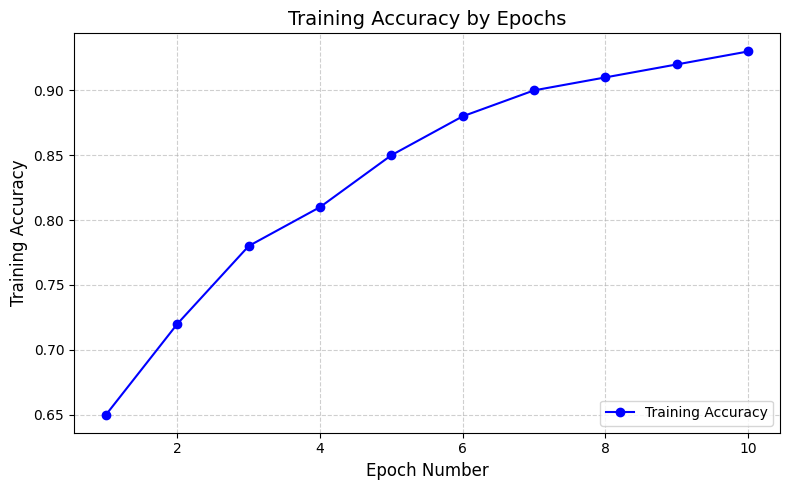

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(epoch_nums, training_acc, marker='o', linestyle='-', color='b', label='Training Accuracy')

# Add labels and title
plt.xlabel('Epoch Number', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)
plt.title('Training Accuracy by Epochs', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


Accuracy

In [15]:
test_accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.9710


Confusion Matrix

In [16]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cf_matrix)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))


Confusion Matrix:
 [[14  0  3  0]
 [ 0 12  0  3]
 [ 0  0 23  0]
 [ 0  0  0 14]]

Classification Report:
               precision    recall  f1-score   support

     bicycle       1.00      0.82      0.90        17
         car       1.00      0.80      0.89        15
  motor bike       0.88      1.00      0.94        23
       truck       0.82      1.00      0.90        14

    accuracy                           0.91        69
   macro avg       0.93      0.91      0.91        69
weighted avg       0.93      0.91      0.91        69

